In [191]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV

from joblib import dump, load

<h3>Wrangling-EDA</h3>

In [169]:
# opening file
path_to_cvs = "../data/raw/music_genre.csv/music_genre.csv"
df = pd.read_csv(path_to_cvs)
df.head(3)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.7920,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.9500,D,0.124,-7.043,Minor,0.0300,115.002,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.0118,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic


In [170]:
# splitting and converting date into int
print(df['obtained_date'].unique())

def conver_into_int(data):
    """Extracting "date" value"""
    try:
        return int(data[0])
    except:
        return 0


df['obtained_day'] = df['obtained_date'].apply(lambda x: conver_into_int(x))
mask_0 = df['obtained_day'] == 0
df = df[~mask_0]
df.reset_index(drop=True, inplace=True)
df.shape

['4-Apr' '3-Apr' '5-Apr' '1-Apr' nan '0/4']


(49999, 19)

In [171]:
# dropping NaNs
df = df.dropna(how="all")
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       49999 non-null  float64
 1   artist_name       49999 non-null  object 
 2   track_name        49999 non-null  object 
 3   popularity        49999 non-null  float64
 4   acousticness      49999 non-null  float64
 5   danceability      49999 non-null  float64
 6   duration_ms       49999 non-null  float64
 7   energy            49999 non-null  float64
 8   instrumentalness  49999 non-null  float64
 9   key               49999 non-null  object 
 10  liveness          49999 non-null  float64
 11  loudness          49999 non-null  float64
 12  mode              49999 non-null  object 
 13  speechiness       49999 non-null  float64
 14  tempo             49999 non-null  object 
 15  obtained_date     49999 non-null  object 
 16  valence           49999 non-null  float6

In [172]:
# converting "tempo" column into float and dropping error values that cannot be converted
def checking(data):
    try:
        return float(data)
    except:
        return -1

df['tempo'] = df['tempo'].apply(lambda x: checking(x))
mask_5 = df['tempo'] == -1
# df[mask_5]['tempo'] = df[~mask_5]['tempo'].mean()
df = df[~mask_5]
df.reset_index(drop=True, inplace=True)
df.shape

(45020, 19)

In [173]:
# adding a new feature from the "track_name" column
df['track_name_len_size'] = df['track_name'].apply(lambda x: len(x.split()))

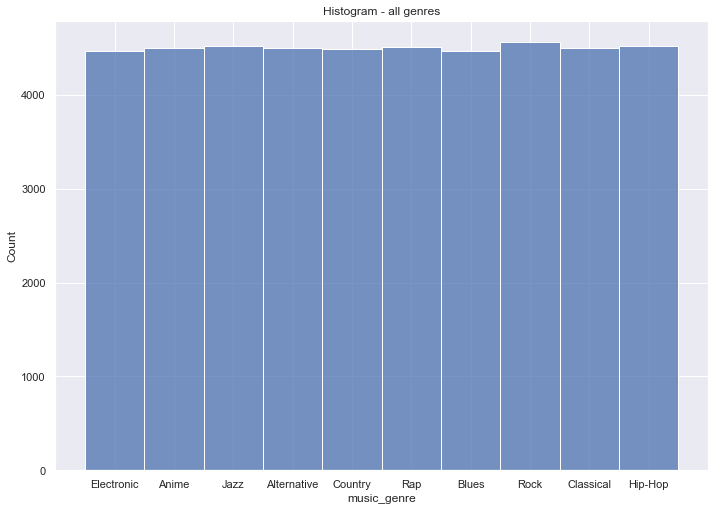

In [174]:
# looking at the distribution of the target classes
_ = sns.histplot(data=df, x="music_genre").set_title("Histogram - all genres")

<h3>Pre-Processing</h3>

In [175]:
# checking unique values for categorical features before creating dummies
df['key'].unique()

array(['A#', 'D', 'G#', 'C#', 'F#', 'B', 'G', 'F', 'A', 'C', 'E', 'D#'],
      dtype=object)

In [176]:
df['mode'].unique()

array(['Minor', 'Major'], dtype=object)

In [177]:
# dropping irrelevant features columns
data = df[["instance_id", 'track_name_len_size', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'obtained_day', 'valence', 'music_genre']]

data.columns

Index(['instance_id', 'track_name_len_size', 'popularity', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'obtained_day',
       'valence', 'music_genre'],
      dtype='object')

In [178]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45020 entries, 0 to 45019
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   instance_id          45020 non-null  float64
 1   track_name_len_size  45020 non-null  int64  
 2   popularity           45020 non-null  float64
 3   acousticness         45020 non-null  float64
 4   danceability         45020 non-null  float64
 5   duration_ms          45020 non-null  float64
 6   energy               45020 non-null  float64
 7   instrumentalness     45020 non-null  float64
 8   key                  45020 non-null  object 
 9   liveness             45020 non-null  float64
 10  loudness             45020 non-null  float64
 11  mode                 45020 non-null  object 
 12  speechiness          45020 non-null  float64
 13  tempo                45020 non-null  float64
 14  obtained_day         45020 non-null  int64  
 15  valence              45020 non-null 

In [179]:
def show_graph(data, col_names):
    """show the distribution of the categorical features"""
    for i in col_names:
        _ = sns.histplot(data=data, x=i).set_title(i)
        plt.show()

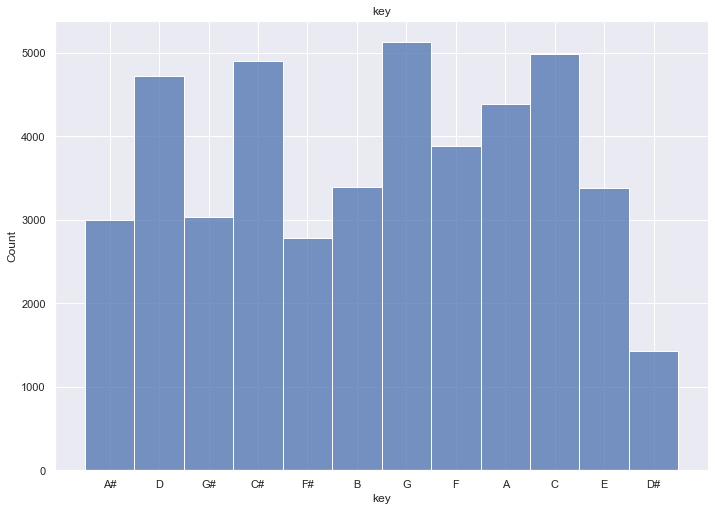

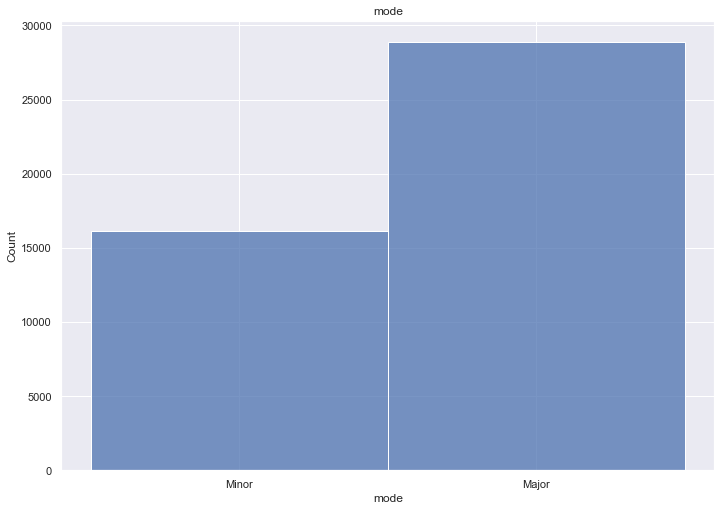

In [180]:
show_graph(data, ["key", 'mode'])

In [181]:
def see_desc(data, col_names):
    """look at the description of each numerical feature"""
    for i in col_names:
        print(f"COLUMN NAME: {i}")
        print(data[i].describe())
        print(f"Missing values: {data[i].isna().sum()}")
        print("\n")

In [182]:
col_names = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'obtained_day','valence']

see_desc(data, col_names)

COLUMN NAME: popularity
count    45020.000000
mean        44.263327
std         15.553972
min          0.000000
25%         34.000000
50%         45.000000
75%         56.000000
max         99.000000
Name: popularity, dtype: float64
Missing values: 0


COLUMN NAME: acousticness
count    45020.000000
mean         0.306596
std          0.341391
min          0.000000
25%          0.020100
50%          0.145000
75%          0.551000
max          0.996000
Name: acousticness, dtype: float64
Missing values: 0


COLUMN NAME: danceability
count    45020.000000
mean         0.558532
std          0.178858
min          0.059600
25%          0.442000
50%          0.568000
75%          0.687000
max          0.986000
Name: danceability, dtype: float64
Missing values: 0


COLUMN NAME: duration_ms
count    4.502000e+04
mean     2.211695e+05
std      1.276884e+05
min     -1.000000e+00
25%      1.747230e+05
50%      2.194385e+05
75%      2.686400e+05
max      4.497994e+06
Name: duration_ms, dtype: float6

In [183]:
# dropping values that are less than or equal to 0 in "duration_ms"
mask_4 = data['duration_ms'] <= 0
data = data[~mask_4]
data.reset_index(drop=True, inplace=True)
data.shape

(40560, 17)

In [184]:
"""
# removing outliers
col_names = ['instrumentalness', 'liveness', 'loudness', 'speechiness']

def remove_outliser(data, col_names):
    for i in col_names:
        data = data[np.abs(data[i] - data[i].mean()) <= (2.5 * data[i].std())]
        
    return data

data = remove_outliser(data, col_names)
data.shape
"""

"\n# removing outliers\ncol_names = ['instrumentalness', 'liveness', 'loudness', 'speechiness']\n\ndef remove_outliser(data, col_names):\n    for i in col_names:\n        data = data[np.abs(data[i] - data[i].mean()) <= (2.5 * data[i].std())]\n        \n    return data\n\ndata = remove_outliser(data, col_names)\ndata.shape\n"

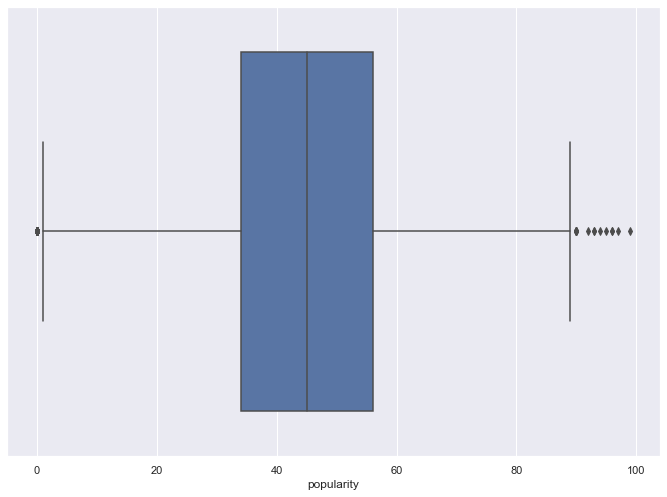

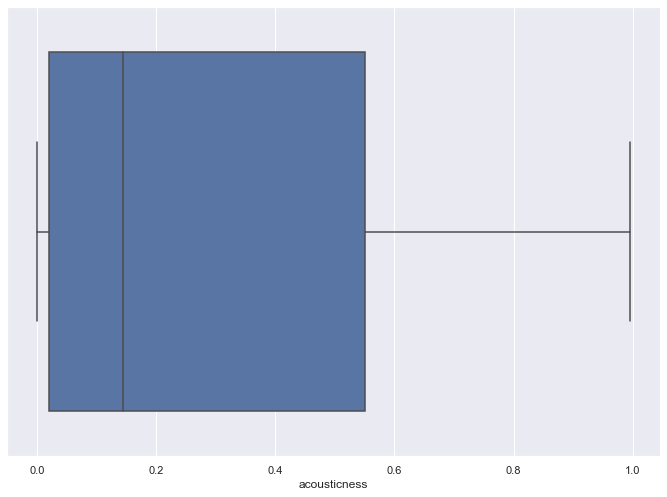

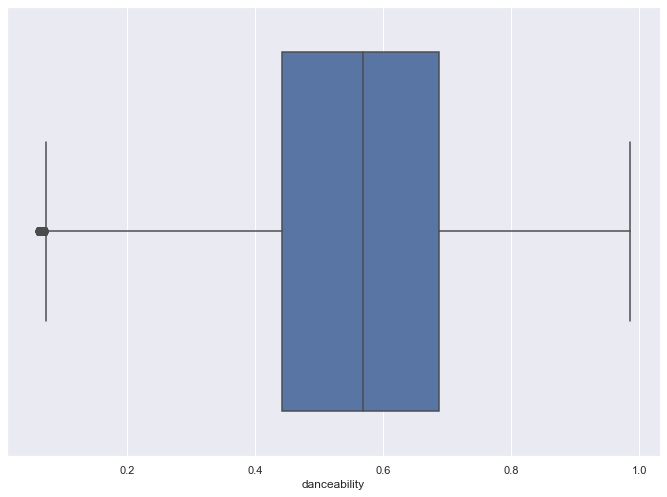

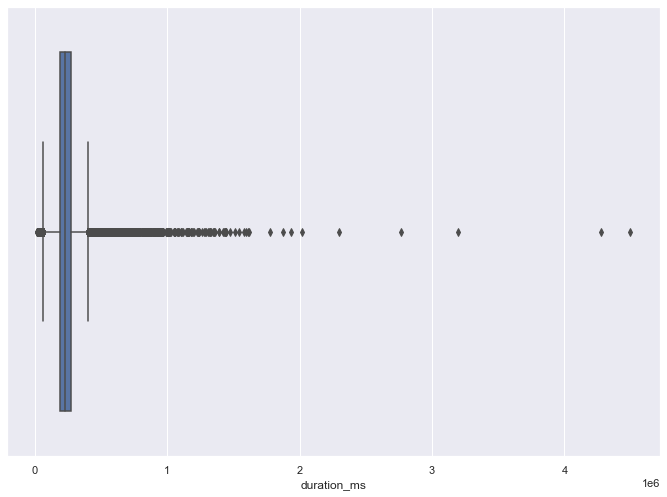

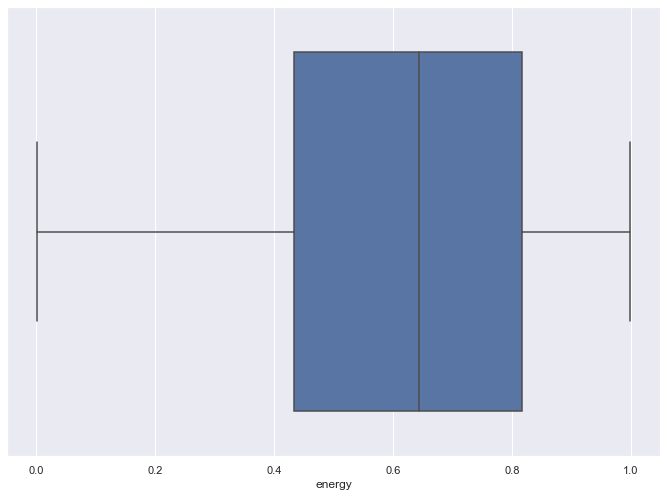

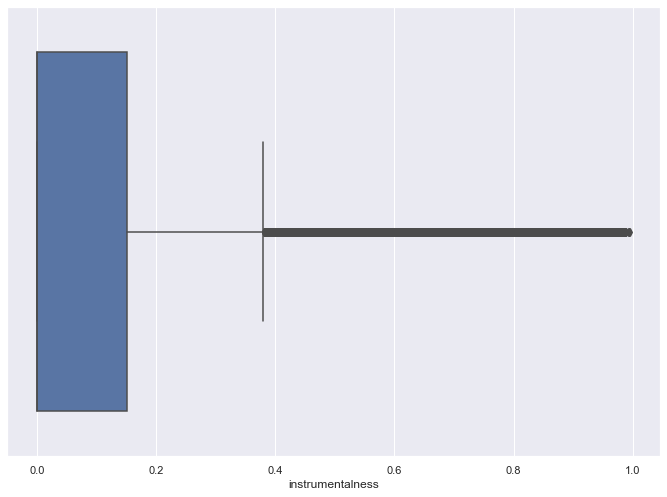

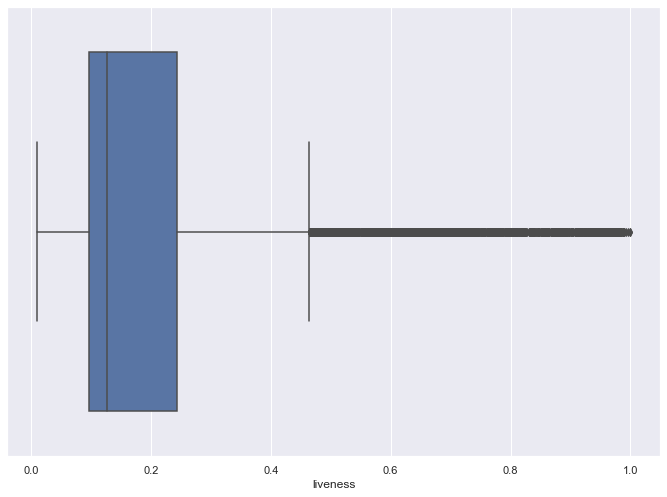

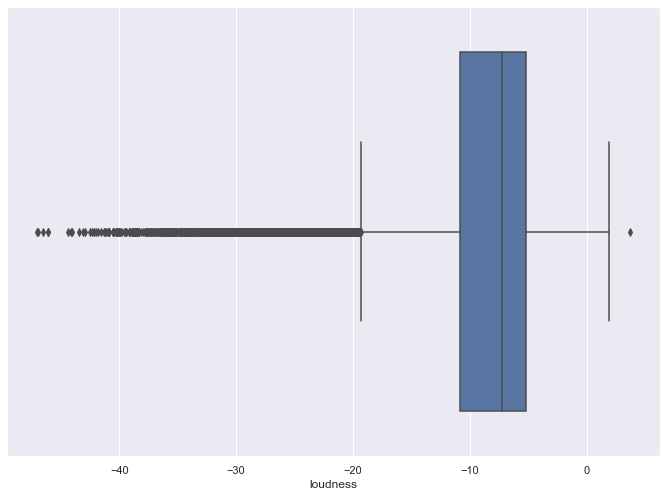

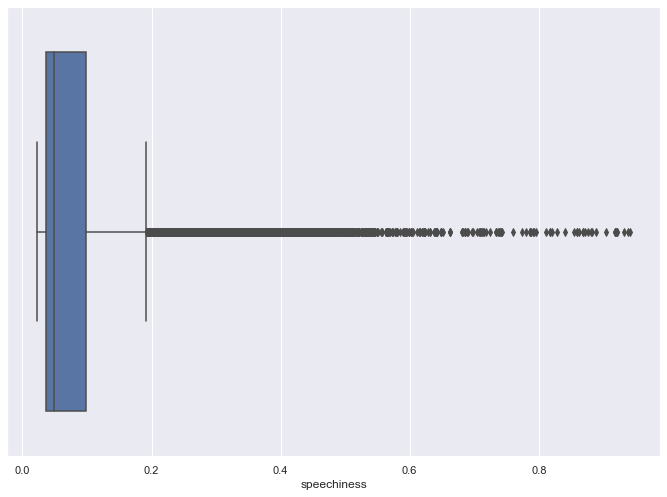

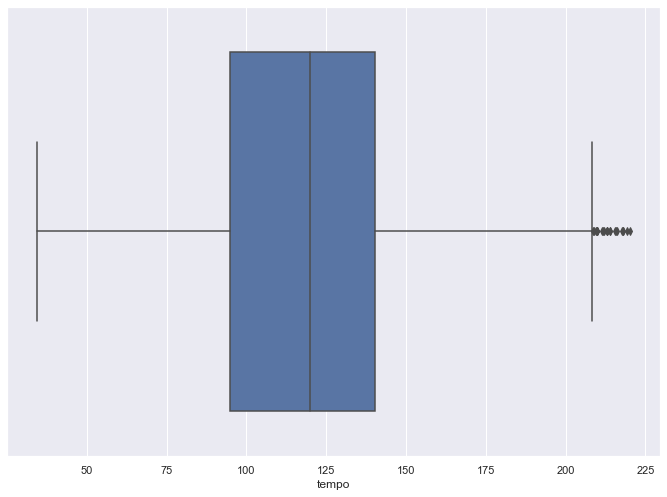

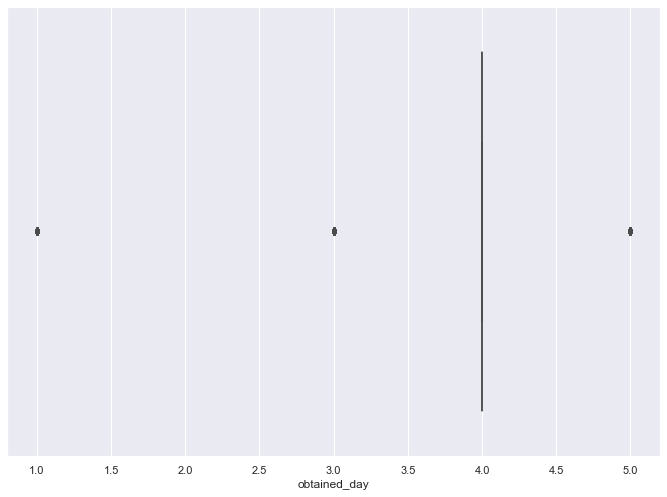

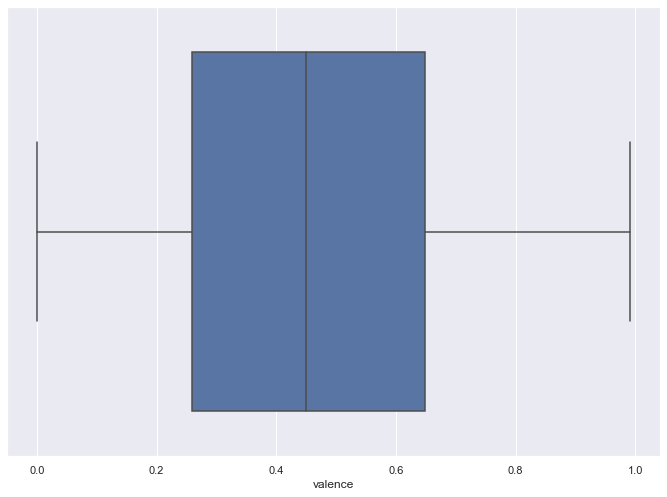

In [185]:
#checking outliers
col_names = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'obtained_day','valence']

def check_outliers(data, col_names):
    for i in col_names:
        _ = sns.boxplot(x=data[i])
        plt.show()
        
check_outliers(data, col_names)

In [186]:
X, y = data.drop(labels=['music_genre'], axis=1), data['music_genre']
X.shape, y.shape

((40560, 16), (40560,))

In [187]:
# getting dummies
X = pd.get_dummies(X, prefix=['key', 'mode'], drop_first=True)
X.shape, X.head(3)

((40560, 26),
    instance_id  track_name_len_size  popularity  acousticness  danceability  \
 0      46652.0                    3        31.0       0.01270         0.622   
 1      30097.0                    1        28.0       0.00306         0.620   
 2      62177.0                    1        34.0       0.02540         0.774   
 
    duration_ms  energy  instrumentalness  liveness  loudness  ...  key_C  \
 0     218293.0   0.890           0.95000     0.124    -7.043  ...      0   
 1     215613.0   0.755           0.01180     0.534    -4.617  ...      0   
 2     166875.0   0.700           0.00253     0.157    -4.498  ...      0   
 
    key_C#  key_D  key_D#  key_E  key_F  key_F#  key_G  key_G#  mode_Minor  
 0       0      1       0      0      0       0      0       0           1  
 1       0      0       0      0      0       0      0       1           0  
 2       1      0       0      0      0       0      0       0           0  
 
 [3 rows x 26 columns])

In [188]:
"""
# running PCA for dummies
from sklearn.preprocessing import Normalizer

col_names = ['key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#',
       'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'mode_Minor']
df_reduce = X[col_names]

pca = PCA(n_components=4)
df_reduced = pca.fit_transform(df_reduce)
# print(df_reduced.shape)

print(pca.explained_variance_ratio_)
# print(pd.DataFrame(pca.components_, columns=col_names, index=["PC_1", "PC_2", "PC_3", "PC_4"]))

df_reduced = pd.DataFrame(df_reduced, columns=["PC_1", "PC_2", "PC_3", "PC_4"])

print(X.shape, df_reduced.shape)

X = pd.concat([X[['popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence']], df_reduced], axis=1)

X.head(3)
"""

'\n# running PCA for dummies\nfrom sklearn.preprocessing import Normalizer\n\ncol_names = [\'key_A#\', \'key_B\', \'key_C\', \'key_C#\', \'key_D\', \'key_D#\',\n       \'key_E\', \'key_F\', \'key_F#\', \'key_G\', \'key_G#\', \'mode_Minor\']\ndf_reduce = X[col_names]\n\npca = PCA(n_components=4)\ndf_reduced = pca.fit_transform(df_reduce)\n# print(df_reduced.shape)\n\nprint(pca.explained_variance_ratio_)\n# print(pd.DataFrame(pca.components_, columns=col_names, index=["PC_1", "PC_2", "PC_3", "PC_4"]))\n\ndf_reduced = pd.DataFrame(df_reduced, columns=["PC_1", "PC_2", "PC_3", "PC_4"])\n\nprint(X.shape, df_reduced.shape)\n\nX = pd.concat([X[[\'popularity\', \'acousticness\', \'danceability\', \'energy\',\n       \'instrumentalness\', \'liveness\', \'loudness\', \'speechiness\', \'tempo\',\n       \'valence\']], df_reduced], axis=1)\n\nX.head(3)\n'

In [189]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28392, 26), (12168, 26), (28392,), (12168,))

<h3>Modeling</h3>

In [25]:
# creating Piplines 
pipe_1 = Pipeline([
    ("scaler", StandardScaler()),
    ('svc', SVC())
])

pipe_2 = Pipeline([
    ("scaler", StandardScaler()),
    ("rfc", RandomForestClassifier(random_state=0, n_jobs=-1))
])

pipe_3 = Pipeline([
    ('gnb', GaussianNB())
])

pipe_4 = Pipeline([
    ("scaler", StandardScaler()),
    ('knc', KNeighborsClassifier(n_jobs=-1))
])

pipe_5 = Pipeline([
    ("scaler", StandardScaler()),
    ('gcl', GradientBoostingClassifier(random_state=0))
])

In [26]:
# training and getting a score from each estimator
pipline_list = [
    ("SCV", pipe_1),
    ("RandomForestClassifier", pipe_2),
    ("GaussianNB", pipe_3),
    ("KNeighborsClassifier", pipe_4),
    ("GradientBoostingClassifier", pipe_5),
]

def test_score(list_piplines):
    for i in list_piplines:
        scores = cross_val_score(i[1], X_train, y_train, cv=3)
        print(f"CV score for {i[0]}: {scores.mean()}")
        i[1].fit(X_train, y_train)
        
test_score(pipline_list)

CV score for SCV: 0.5576923076923076
CV score for RandomForestClassifier: 0.5681530008453085
CV score for GaussianNB: 0.37757114680191606
CV score for KNeighborsClassifier: 0.42187940264863344
CV score for GradientBoostingClassifier: 0.584319526627219


In [194]:
# feature importance 
coeff_values = pipe_2.named_steps['rfc'].feature_importances_
feature_importances_list = []

for index, i in enumerate(coeff_values):
    feature_importances_list.append((i, X_train.columns.values[index]))
    
print(f"---FEATURE IMPORTANCE---")
feature_importances_list = sorted(feature_importances_list, reverse=True)
for i in feature_importances_list[:10]:
    print(f"{i[1]}: {i[0]}")

---FEATURE IMPORTANCE---
popularity: 0.1611126711929962
speechiness: 0.0809879299488222
loudness: 0.07949518881749229
danceability: 0.07880762633241221
acousticness: 0.07613349377996265
instrumentalness: 0.07472296140762454
energy: 0.06922694686274801
instance_id: 0.0611841770284012
valence: 0.06087620180741804
duration_ms: 0.057995178956584785


Confusion matrix - RandomForestClassifier


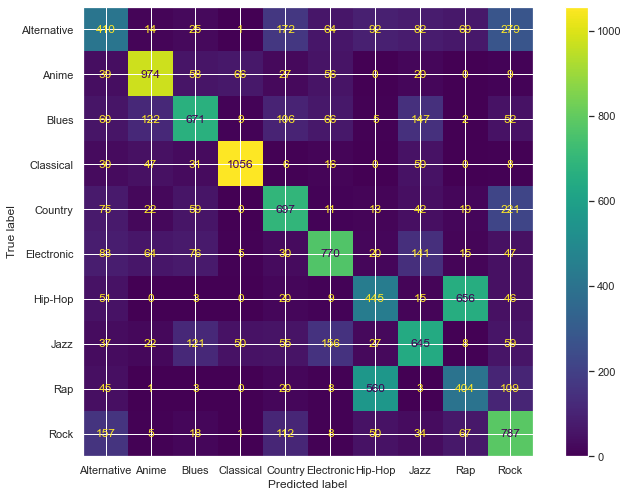

In [41]:
# predicting values
y_pred = pipe_2.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=pipe_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_2.classes_)
disp.plot()
print(f"Confusion matrix - RandomForestClassifier")
plt.show()

<h3>Hyper-tunning</h3>

In [46]:
# hypertunning final estimator
model_final_rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
model_final_rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [47]:
n_estimators = [int(x) for x in range(150, 500, 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in range(10, 110, 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
}

print(random_grid)

{'n_estimators': [150, 200, 250, 300, 350, 400, 450], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [48]:
rs_rfc = RandomizedSearchCV(estimator=model_final_rfc,
                           param_distributions=random_grid,
                           n_iter=100,
                           cv=3,
                           verbose=2,
                           random_state=42,
                           n_jobs=-1)

rs_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 45.7min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [150, 200, 250, 300,
                                                         350, 400, 450]},
                   random_state=42, verbose=2)

In [165]:
model_final_rfc_tuned = rs_rfc.best_estimator_
rs_rfc.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=60, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=450, n_jobs=-1, random_state=42)

Confusion matrix - RandomForestClassifier


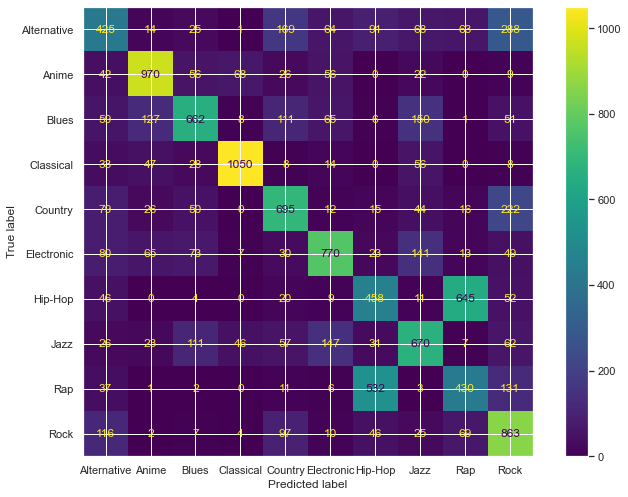

In [166]:
# predicting values
y_pred = model_final_rfc_tuned.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model_final_rfc_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_final_rfc_tuned.classes_)
disp.plot()
print(f"Confusion matrix - RandomForestClassifier")
plt.show()

In [167]:
model_rfc_cv_score = RandomForestClassifier(bootstrap=False, max_depth=60, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=450, n_jobs=-1, random_state=42)

scores = cross_val_score(model_rfc_cv_score, X_train, y_train, cv=3)
print(f"CV score for RandomForestClassifier: {scores.mean()}")

CV score for RandomForestClassifier: 0.578261482107636


In [193]:
# saving model
dump(model_final_rfc_tuned, "../model/model_rfc.joblib")

['../model/model_rfc.joblib']

<h3>Summary</h3>

<p>I was able to achieve 57-58% accuracy. The final chosen model was RFC because it takes less time to train and the accuracy of estimation is pretty much the same as "GradientBoostingClassifier". 

Top feature importance: popularity, speechiness, loudness, danceability.

Ways to improve: if you use the "artist_name" column for our prediction, then we could boost accuracy up to 5%, but at the same time we will slow down the training process and will increase the complexity of the model. Secondly, we could add more data, by dealing with missing values (replacing with min/max/mean). Finally, we could apply NLP for the "track_name" column, so we can classify it properly based on "sentiment analysis". </p>